# Context Compatibility

In [1]:
# per default - the preprocessing step for jaccard and clustering is deactivated
do_preprocessing = False

## SemMedDB Connection

In [2]:
import psycopg2


pg_cred = {
  "POSTGRES_DB":   "",
  "POSTGRES_HOST" : "",
  "POSTGRES_PORT" : "",
  "POSTGRES_USER" : "",
  "POSTGRES_PW" :  ""
}

connection_str = "dbname='{}' user='{}' host='{}' port='{}' password='{}'".format(
        pg_cred["POSTGRES_DB"],
        pg_cred["POSTGRES_USER"],
        pg_cred["POSTGRES_HOST"],
        pg_cred["POSTGRES_PORT"],
        pg_cred["POSTGRES_PW"])

conn = psycopg2.connect(connection_str)
print('connected')

connected


## PubMed Metadatabase Connection

In [3]:
pg_cred_meta = {
  "POSTGRES_DB":   "",
  "POSTGRES_HOST" : "",
  "POSTGRES_PORT" : "",
  "POSTGRES_USER" : "",
  "POSTGRES_PW" :  ""
}

connection_str_meta = "dbname='{}' user='{}' host='{}' port='{}' password='{}'".format(
        pg_cred_meta["POSTGRES_DB"],
        pg_cred_meta["POSTGRES_USER"],
        pg_cred_meta["POSTGRES_HOST"],
        pg_cred_meta["POSTGRES_PORT"],
        pg_cred_meta["POSTGRES_PW"])

if do_preprocessing:
    conn_meta = psycopg2.connect(connection_str_meta)
    print('connected')

connected


## Queries

In [4]:
# only causes with at least 3 occurrences
mv_cause = "mv_cause_2"
mv_ddi_gen = "mv_ddi_gen"
mv_ddi_function = "mv_ddi_function"


query_cause = "SELECT pmid, subject_cui, object_cui FROM {}".format(mv_cause)
query_ddi_gen = "SELECT pmid, subject_cui, object_cui FROM {} ".format(mv_ddi_gen)
query_ddi_gen_1_dg = "SELECT pmid, subject_cui, object_cui FROM {} WHERE (object_semtype = 'gngm' OR object_semtype = 'aapp') AND (subject_semtype = 'clnd' OR subject_semtype = 'phsu' OR subject_semtype ='sbst')".format(mv_ddi_gen)
query_ddi_gen_2_gd = "SELECT pmid, subject_cui, object_cui FROM {} WHERE (subject_semtype = 'gngm' OR subject_semtype = 'aapp') AND (object_semtype = 'clnd' OR object_semtype = 'phsu' OR object_semtype ='sbst')".format(mv_ddi_gen)


query_ddi_function_1_dg = "SELECT pmid, subject_cui, object_cui FROM {} WHERE (object_semtype = 'gngm' OR object_semtype = 'aapp') AND (subject_semtype = 'clnd' OR subject_semtype = 'phsu' OR subject_semtype ='sbst')".format(mv_ddi_function)
query_ddi_function_2_gf = "SELECT pmid, subject_cui, object_cui FROM {} WHERE \
(subject_semtype = 'gngm' OR subject_semtype = 'aapp') AND \
(object_semtype = 'biof' OR object_semtype = 'phsf' OR object_semtype ='orgf' OR object_semtype = 'menp' \
OR object_semtype = 'ortf' OR object_semtype = 'celf' OR object_semtype ='moft' OR object_semtype = 'genf' \
OR object_semtype = 'patf' OR object_semtype = 'dsyn' OR object_semtype = 'mobd' OR object_semtype = 'neop' \
OR object_semtype = 'comd' OR object_semtype = 'emod')".format(mv_ddi_function)

query_cause_correct = "SELECT pmid, subject_cui, object_cui FROM {}".format(mv_cause)
query_ddi_correct = "SELECT '0', d1, d2 FROM mv_ddi_correct"

query_mesh_desc = "SELECT AM.pmid, MH.descriptorui \
FROM pubmed_metadata.meshheading MH JOIN pubmed_metadata.article_meshheading AM \
ON MH.meshid = AM.meshid WHERE AM.pmid IN (SELECT pmid FROM t_pmid_with_pred)"

query_doc_chemical_desc = "SELECT pmid, chemicalui FROM pubmed_metadata.article_chemical \
WHERE pmid IN (SELECT pmid FROM t_pmid_with_pred)"

query_doc_titles = "SELECT pmid, title FROM pubmed_metadata.pubmedarticle \
WHERE pmid IN (SELECT pmid FROM t_pmid_with_pred)"

query_doc_author_ids = """SELECT pmid, authorid FROM pubmed_metadata.article_author
WHERE pmid IN (SELECT pmid FROM t_pmid_with_pred)"""


---
# Preprocessing of Document Pair Similarity

In [5]:
from model.knowledgegraph import load_kg_facts
from model.contextcompatibility import load_kg_facts_with_doc_index, preprocess_document_pairs_for_experiment


experiments = ["cause", "ddi_gene"]
metadata_name = ["chemical", "title", "authors", "mesh"]
metadata_to_process =  [query_doc_chemical_desc, query_doc_titles, query_doc_author_ids, query_mesh_desc]
requires_splitting = [False, True, False, True]

## Preprocess Cause Experiment

In [6]:
if do_preprocessing:
    print('loading cause facts....')
    idx_subject, idx_object, fact2docs = load_kg_facts_with_doc_index(conn, query_cause)
    preprocess_document_pairs_for_experiment(experiments[0], metadata_to_process, metadata_name, 
                                             idx_subject, idx_object, fact2docs, fact2docs)

## Preprocess DDI Gene Experiment

In [7]:
if do_preprocessing:
    print('loading ddi gene facts...')
    _, idx_pmid_dg_o, fact2docsRel1 = load_kg_facts_with_doc_index(conn, query_ddi_gen_1_dg)
    idx_pmid_gd_s, _, fact2docsRel2 = load_kg_facts_with_doc_index(conn, query_ddi_gen_2_gd)
    
    preprocess_document_pairs_for_experiment(experiments[1], metadata_to_process, metadata_name, 
                                             idx_pmid_gd_s, idx_pmid_dg_o, fact2docsRel1, fact2docsRel2)

---
# Experiments with Jaccard

In [8]:
from model.contextcompatibility import do_experiment_with_context_pairs
thresholds_to_check = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## Causes Experiment with Document Pairs

In [9]:
print('loading correct cause facts...')
idx_correct_cause, _ = load_kg_facts(conn, query_cause)

cause_results = do_experiment_with_context_pairs(experiments[0], metadata_to_process, metadata_name,
                                                 thresholds_to_check, idx_correct_cause)

loading correct cause facts...
loading data from file: preprocessed_context_compatibility/fact2maxjaccard_cause_chemical.pkl ...
7978099 jaccard coefficients loaded
checking threshold: 0.0
95037 of 7978099 derived facts are correct
checking threshold: 0.1
75055 of 1652754 derived facts are correct
checking threshold: 0.2
65846 of 1016528 derived facts are correct
checking threshold: 0.3
53908 of 612316 derived facts are correct
checking threshold: 0.4
44424 of 415578 derived facts are correct
checking threshold: 0.5
41937 of 390933 derived facts are correct
checking threshold: 0.6
29335 of 206587 derived facts are correct
checking threshold: 0.7
26786 of 189893 derived facts are correct
checking threshold: 0.8
26340 of 187619 derived facts are correct
checking threshold: 0.9
26151 of 186721 derived facts are correct
checking threshold: 1.0
26150 of 186713 derived facts are correct
loading data from file: preprocessed_context_compatibility/fact2maxjaccard_cause_title.pkl ...
7978099 jac

In [10]:
from model.contextcompatibility import print_tab_seperated, show_precision_recall_curve

print_tab_seperated(cause_results)

chemical
7978099	95037
1652754	75055
1016528	65846
612316	53908
415578	44424
390933	41937
206587	29335
189893	26786
187619	26340
186721	26151
186713	26150
title
7978099	95037
6794609	93733
1621720	74990
221296	36519
50030	15289
22318	8853
13920	6402
12317	5879
11952	5732
11866	5701
11864	5699
authors
7978099	95037
75827	21826
40151	14545
26085	10717
20243	8829
18111	8030
14718	6797
13591	6385
13158	6209
12911	6104
12900	6101
mesh
7978099	95037
6287737	93687
3162930	84649
992139	61449
231706	33800
58657	15982
18191	7763
12634	5980
11845	5686
11633	5608
11623	5604


chemical
authors
mesh


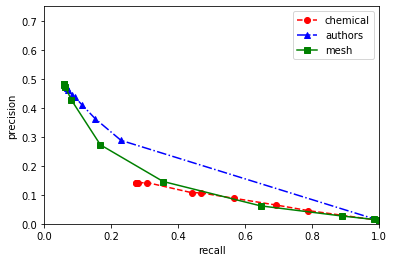

In [11]:
cause_kg_correct_facts = 95037

cause_results_new = cause_results.copy()
del cause_results_new["title"]

show_precision_recall_curve(cause_results_new, cause_kg_correct_facts, 'prec_recall_jaccard_cause.pdf')

## DDI Gene Experiment with Document Pairs

In [12]:
print('loading correct interactions from semmed...')
idx_subjects_correct_ddi_gene, _ = load_kg_facts(conn, query_ddi_correct)

ddi_gen_results = do_experiment_with_context_pairs(experiments[1], metadata_to_process, metadata_name,
                  thresholds_to_check, idx_subjects_correct_ddi_gene)


loading correct interactions from semmed...
loading data from file: preprocessed_context_compatibility/fact2maxjaccard_ddi_gene_chemical.pkl ...
753899 jaccard coefficients loaded
checking threshold: 0.0
55370 of 753899 derived facts are correct
checking threshold: 0.1
31432 of 221670 derived facts are correct
checking threshold: 0.2
17819 of 78987 derived facts are correct
checking threshold: 0.3
9477 of 29045 derived facts are correct
checking threshold: 0.4
5752 of 14282 derived facts are correct
checking threshold: 0.5
4253 of 9656 derived facts are correct
checking threshold: 0.6
2454 of 4381 derived facts are correct
checking threshold: 0.7
1759 of 2927 derived facts are correct
checking threshold: 0.8
1540 of 2545 derived facts are correct
checking threshold: 0.9
1446 of 2385 derived facts are correct
checking threshold: 1.0
1445 of 2384 derived facts are correct
loading data from file: preprocessed_context_compatibility/fact2maxjaccard_ddi_gene_title.pkl ...
753899 jaccard coef

## DDI Gene Experiment

In [13]:
print_tab_seperated(ddi_gen_results)

chemical
753899	55370
221670	31432
78987	17819
29045	9477
14282	5752
9656	4253
4381	2454
2927	1759
2545	1540
2385	1446
2384	1445
title
753899	55370
337349	37558
59848	13719
8072	3417
2177	1319
1475	996
1339	924
1330	918
1316	911
1311	909
1311	909
authors
753899	55370
6452	3168
4407	2404
3160	1861
2600	1576
2310	1444
1912	1256
1675	1111
1586	1064
1534	1035
1534	1035
mesh
753899	55370
279697	35319
66771	16249
13754	5791
3936	2328
1973	1344
1441	1013
1336	930
1322	919
1314	912
1313	911


chemical
authors
mesh


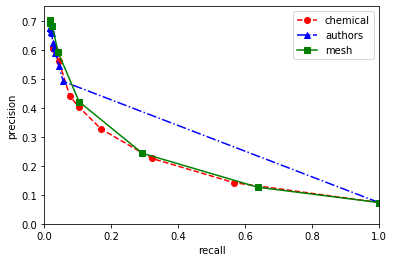

In [14]:
ddi_gene_kg_correct_facts = 55370

ddi_gen_results_new = ddi_gen_results.copy()
del ddi_gen_results_new["title"]

show_precision_recall_curve(ddi_gen_results_new, ddi_gene_kg_correct_facts, 'prec_recall_jaccard_ddi_gene.pdf')

---
# Clustering

In [15]:
query_doc_titles = "SELECT pmid, title FROM pubmed_metadata.pubmedarticle \
WHERE pmid IN (SELECT pmid FROM t_pmid_with_pred)"


query_doc_abstracts = """
SELECT pmid, array_to_string(abstracts, ' ') FROM pubmed_metadata.pubmedarticle  
WHERE abstracts IS NOT NULL AND array_length(abstracts, 1) > 0 AND
pmid IN (SELECT pmid FROM t_pmid_with_pred)""" 

In [16]:
from model.librarygraph import load_lg_facts
from model.experiments import do_cause_experiment_with_context, do_ddi_gene_experiment_with_context
from model.clustering import load_dumped_clusters, combine_document_clusters, preprocess_and_dump_clustering

In [17]:
clusters_to_check = [2, 5, 10, 15, 30, 45, 60, 100, 200, 300, 400, 500, 1000, 2000, 4000, 6000, 10000, 20000, 50000, 100000]
clustering_types = ["clustering_kmeans_title", "clustering_kmeans_abstract"]

In [18]:
if do_preprocessing:
    preprocess_and_dump_clustering(conn_meta, query_doc_titles, clustering_types[0], clusters_to_check)
    preprocess_and_dump_clustering(conn_meta, query_doc_abstracts, clustering_types[1], clusters_to_check)

## Cause Experiment

In [19]:
print('load facts from semmeddb and building index...')
idx_cause = load_lg_facts(conn, query_cause)
print('load facts from semmeddb and building index...')
idx_correct_cause, _ = load_kg_facts(conn, query_cause)

results_type_clustering_cause = {}
for c in clustering_types:
    results_clustering_cause = []
    for k in clusters_to_check:
        print('='*60)
        print('cluster context: {}'.format(c))
        print('cluster k: {}'.format(k))
        cluster2docs = load_dumped_clusters(c, k)
        # now do experiment
        idx_contexts = combine_document_clusters(cluster2docs, idx_cause)
        correct, obtained = do_cause_experiment_with_context(idx_contexts, idx_correct_cause)
        results_clustering_cause.append((k, correct, obtained))
        print('='*60)
    results_type_clustering_cause[c] = results_clustering_cause

del idx_cause
del idx_correct_cause

load facts from semmeddb and building index...
load facts from semmeddb and building index...
cluster context: clustering_kmeans_title
cluster k: 2
load cluster contexts from preprocessed_context_compatibility/clustering_kmeans_title.k2.pkl...
2 cluster contexts are loaded
computing context clusters... [2 / 2]
deriving new facts...
7936775 facts derived
verifying facts in semmeddb...
95000 of 7936775 derived facts are correct
cluster context: clustering_kmeans_title
cluster k: 5
load cluster contexts from preprocessed_context_compatibility/clustering_kmeans_title.k5.pkl...
5 cluster contexts are loaded
computing context clusters... [5 / 5]
deriving new facts...
7918004 facts derived
verifying facts in semmeddb...
94986 of 7918004 derived facts are correct
cluster context: clustering_kmeans_title
cluster k: 10
load cluster contexts from preprocessed_context_compatibility/clustering_kmeans_title.k10.pkl...
10 cluster contexts are loaded
computing context clusters... [10 / 10]
deriving ne

In [20]:
for c, results_clustering_cause in results_type_clustering_cause.items():
    print("="*60)
    print(c)
    for k, correct, obtained in results_clustering_cause:
        print('{}\t{}\t{}'.format(k, obtained, correct))

clustering_kmeans_title
2	7936775	95000
5	7918004	94986
10	7914607	94924
15	7555056	94429
30	7602534	94510
45	6704104	92726
60	7480457	94234
100	7714827	94587
200	3776098	86351
300	6332995	92227
400	6185806	91788
500	2564974	81463
1000	5856369	91056
2000	5042214	89073
4000	4300333	86592
6000	3763408	84135
10000	2486307	77845
20000	1990999	73225
50000	1075800	62219
100000	890000	56300
clustering_kmeans_abstract
2	7597395	94753
5	7244456	94604
10	7573101	94656
15	7294232	94437
30	7177428	94162
45	7208165	94134
60	5183946	91773
100	6658499	93507
200	6354094	93425
300	3380666	86814
400	5996888	92599
500	5752645	92185
1000	5563621	91492
2000	5551689	91130
4000	4659867	88937
6000	4278644	87311
10000	2511950	80883
20000	1346615	72315
50000	789544	62628
100000	517052	54491


jaccard title
clustering titles
clustering abstracts


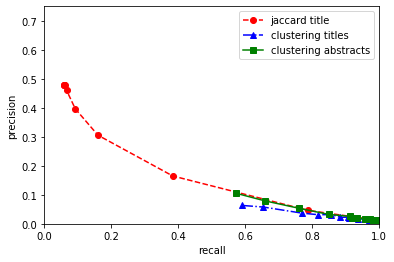

In [21]:
cause_kg_correct_facts = 95037

cluster_cause_results_new = {}
cluster_cause_results_new["jaccard title"] = cause_results["title"]

cl_cause_titles_results = []
for _, obtained, correct in results_type_clustering_cause[clustering_types[0]]:
    cl_cause_titles_results.append((obtained, correct))
    
cl_cause_abstracts_results = []
for _, obtained, correct in results_type_clustering_cause[clustering_types[1]]:
    cl_cause_abstracts_results.append((obtained, correct))
    
cluster_cause_results_new["clustering titles"] = cl_cause_titles_results
cluster_cause_results_new["clustering abstracts"] = cl_cause_abstracts_results




show_precision_recall_curve(cluster_cause_results_new, cause_kg_correct_facts, 'prec_recall_cluster_cause.pdf')

## DDI Gene

In [22]:
print('load facts from semmeddb and building index...')
idx_pmid_dg = load_lg_facts(conn, query_ddi_gen_1_dg)
idx_pmid_gd = load_lg_facts(conn, query_ddi_gen_2_gd)
print('loading correct interactions from semmed...')
ddi_gen_idx_subjects_correct, _ = load_kg_facts(conn, query_ddi_correct)

results_type_clustering_ddi_gene = {}
for c in clustering_types:
    results_clustering_ddi_gene = []
    for k in clusters_to_check:
        print('='*60)
        print('cluster context: {}'.format(c))
        print('cluster k: {}'.format(k))
        cluster2docs = load_dumped_clusters(c, k)
        # now do experiment
        c_idx_pmid_dg = combine_document_clusters(cluster2docs, idx_pmid_dg)
        c_idx_pmid_gd = combine_document_clusters(cluster2docs, idx_pmid_gd)
        correct, obtained = do_ddi_gene_experiment_with_context(c_idx_pmid_dg, c_idx_pmid_gd, ddi_gen_idx_subjects_correct)    
        results_clustering_ddi_gene.append((k, correct, obtained))
        
    results_type_clustering_ddi_gene[c] = results_clustering_ddi_gene
        
del idx_pmid_dg
del idx_pmid_gd
del ddi_gen_idx_subjects_correct

load facts from semmeddb and building index...
loading correct interactions from semmed...
cluster context: clustering_kmeans_title
cluster k: 2
load cluster contexts from preprocessed_context_compatibility/clustering_kmeans_title.k2.pkl...
2 cluster contexts are loaded
computing context clusters... [2 / 2]
computing context clusters... [2 / 2]
deriving new facts...
739540 facts derived
verifying facts in semmeddb...
derived 54767 of 739540 derived facts are correct
cluster context: clustering_kmeans_title
cluster k: 5
load cluster contexts from preprocessed_context_compatibility/clustering_kmeans_title.k5.pkl...
5 cluster contexts are loaded
computing context clusters... [5 / 5]
computing context clusters... [5 / 5]
deriving new facts...
709175 facts derived
verifying facts in semmeddb...
derived 53619 of 709175 derived facts are correct
cluster context: clustering_kmeans_title
cluster k: 10
load cluster contexts from preprocessed_context_compatibility/clustering_kmeans_title.k10.pkl.

In [23]:
for c, results_clustering_ddi_gene in results_type_clustering_ddi_gene.items():
    print("="*60)
    print(c)
    for k, correct, obtained in results_clustering_ddi_gene:
        print('{}\t{}\t{}'.format(k, obtained, correct))

clustering_kmeans_title
2	739540	54767
5	709175	53619
10	572939	47001
15	381976	38355
30	397188	39166
45	187738	24892
60	318839	34267
100	406546	38815
200	94377	16882
300	160380	23135
400	179923	24496
500	69471	13783
1000	153479	21937
2000	121477	18539
4000	88339	15413
6000	65953	13115
10000	35580	8774
20000	26573	7220
50000	14428	4733
100000	9540	3584
clustering_kmeans_abstract
2	668832	51538
5	441478	42885
10	498525	45104
15	400895	39907
30	320669	35242
45	332892	35512
60	245636	30380
100	352100	37350
200	350408	36793
300	124003	20125
400	246708	29702
500	235503	29302
1000	194008	25500
2000	202643	25608
4000	133240	20453
6000	111553	18359
10000	71496	13905
20000	41224	10153
50000	24422	7263
100000	16813	5569


jaccard title
clustering titles
clustering abstracts


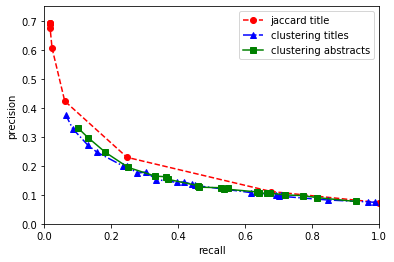

In [24]:
ddi_gene_kg_correct_facts = 55370

cluster_ddi_gene_results_new = {}
cluster_ddi_gene_results_new["jaccard title"] = ddi_gen_results["title"]

cl_ddig_titles_results = []
for _, obtained, correct in results_type_clustering_ddi_gene[clustering_types[0]]:
    cl_ddig_titles_results.append((obtained, correct))
    
cl_ddig_abstracts_results = []
for _, obtained, correct in results_type_clustering_ddi_gene[clustering_types[1]]:
    cl_ddig_abstracts_results.append((obtained, correct))
    
cluster_ddi_gene_results_new["clustering titles"] = cl_ddig_titles_results
cluster_ddi_gene_results_new["clustering abstracts"] = cl_ddig_abstracts_results



show_precision_recall_curve(cluster_ddi_gene_results_new, ddi_gene_kg_correct_facts, 'prec_recall_cluster_ddi_gene.pdf')